In [7]:
import scipy,pylab,numpy
from numpy import *
from scipy import *
from pylab import *
from urllib import urlopen
from gzip import GzipFile
from scipy.spatial import distance
from scipy.spatial.distance import cdist

Linear Classification Problem
================

Let's generate a linear problem, as before.

In [8]:
data = random_sample((1000,2))
labels = (data[:,0]*0.7+data[:,1]*0.4>0.5)
sum(labels)

608

392 608

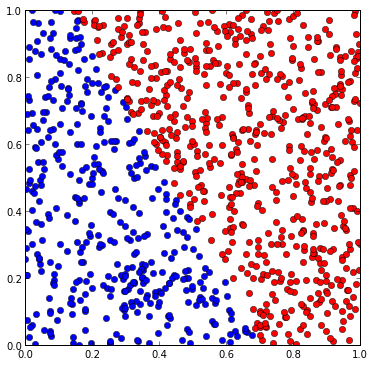

In [9]:
d0 = data[labels==False]
d1 = data[labels]
figure(figsize=(6,6))
plot(d0[:,0],d0[:,1],"bo")
plot(d1[:,0],d1[:,1],"ro")
print len(d0),len(d1)

In [10]:
augmented = concatenate([ones((len(data),1)),data],axis=1)
augmented[:3,:]

array([[ 1.        ,  0.62170828,  0.20003034],
       [ 1.        ,  0.03303012,  0.36609942],
       [ 1.        ,  0.34112627,  0.96111128]])

Least Square Solution
====================

We now want to find a vector $a$ such that $a \cdot x_i \approx c_i$ for all $i$.

We can write this as a matrix and vector equation if we put the measurements into the
rows of  a matrix $X = {x_1\choose x_N}$ and $c = {c_1\choose c_N}$

$$X \cdot a^T =  c$$

In order to solve this, we take the pseudo-inverse of $X$:

$$a^T = X^\dagger \cdot c$$

The pseudo-inverse is a generalization of the inverse matrix for non-rectangular and/or non-full-rank matrices.

In [21]:
a = dot(linalg.pinv(augmented),labels)
d,a0,a1 = a
print d,a0,a1

-0.345563974086 1.27003201537 0.600651460697

Note that the decision boundary is at $a\cdot x = 0.5$, not at $a\cdot x = 0$, since
we want the decision boundary halfway between the two numerical values $0$ and $1$,
corresponding to the labels.

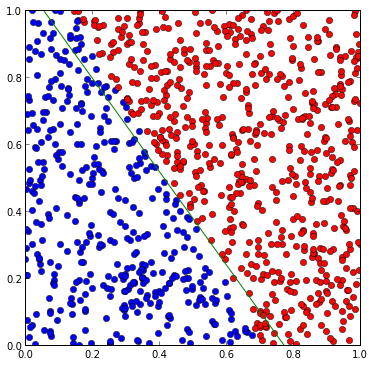

In [24]:
d0 = data[labels<=0]
d1 = data[labels>0]
figure(figsize=(6,6)); xlim((0,1)); ylim((0,1))
plot(d0[:,0],d0[:,1],"bo")
plot(d1[:,0],d1[:,1],"ro")
plot([0,-d/a0+0.5],[-d/a1+0.5,0],"g")

The problem with these kinds of least square solutions is that they are not very good: 
although a linear function can represent the decision function just fine,
it is not a good approximation to the function represented by the labels.

In fact, the function represented by the class labels is, effectively,
the posterior probability distribution, a smooth function, that is in general
better approximate by sigmoids (see below).

Sigmoid Functions
=================

A problem with computing linear least square approximations to
the class label is that we can already see that a linear approximation
can never be very good: the class label is essentially a step function,
but the linear approximant to grows without bounds.

We've already seen that we can interpret the linear functions $g_c(x) = w_c \cdot x$ 
as discriminant functions, but there is no reason to limit ourselves to linear functions.

What we would really like to optimize (in the two-class case) is:

$$\hbox{err} = \sum_i (H(w \cdot x_i) - c_i)^2$$

Here, $H(x) = \left\lfloor x > 0 \right\rfloor$, the Heaviside function.  Unfortunately, we can't optimize that via gradient descent (the only non-linear optimization method that we know) because the Heaviside function does not have a derivative at 0.

We can, however, compute the derivative of a continuous approximation of the Heaviside function, namely a sigmoid function.

$$\sigma_q(x) = \frac{1}{1+e^{-q\,x}}$$

This function looks non-symetrical, but it actually is.  Let's plot it:

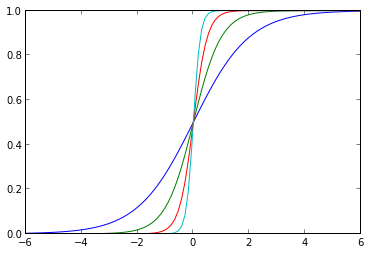

In [9]:
import matplotlib.pyplot as plt
xs = linspace(-6,6,100)
def sig(x,q): return 1.0/(1.0+exp(-q*x))
plt.cla()
plot(xs,sig(xs,1.0))
plot(xs,sig(xs,2.0))
plot(xs,sig(xs,4.0))
plot(xs,sig(xs,8.0))
savefig("temp.png")

Using the sigmoid function, the discriminant functions become:

$$g_c(x) = \sigma(w_c \cdot x)$$

We don't bother introducing the scale factor $q$ because that is already contained in the weight vector $w_c$; that is, since the norm of that vector is not controlled and only the direction of the vector matters for the discriminant boundary, the gradient descent algorithm can itself let $q$ go to infinity in order to obtain better and better approximations to the Heaviside function.

Using the sigmoid function, the discriminant functions become:

$$g_c(x) = \sigma(w_c \cdot x)$$

As before, we compute the gradient of the error:

$$\hbox{err} = \sum_i (\sigma(w\cdot x_i)-c_i)^2$$

Using the same sloppy notation for partial derivatives as before, we can write:

$$\frac{\partial\hbox{err}}{\partial w} = 2 \sum_i (\sigma(w\cdot x_i)-c_i) \sigma'(w\cdot x_i) x_i$$

Note that

$$\sigma'(x) = \sigma(x) (1-\sigma(x))$$



Let's implement this.  Note that the class labels are zero and one again, $c\in\{0,1\}$, matching the output of the sigmoid function $\sigma(x) \in [0,1]$.

In [11]:
def sigmoid(x): return 1.0/(1.0+exp(-x))

In [12]:
w = random_sample((3))
w

array([ 0.41829084,  0.31289947,  0.58718571])

In [13]:
eta = 0.01
for iter in range(500000):
    i = iter%len(data)
    if iter%100000==0: print iter,eta,w
    x = augmented[i]
    c = labels[i]
    s = sigmoid(dot(w,x))
    sprime = s*(1-s)
    delta = s-c
    w -= eta*(s-c)*sprime*x

0 0.01 [ 0.41829084  0.31289947  0.58718571]
100000 0.01 [-4.06342381  6.21008656  2.92048786]
200000 0.01 [-5.49849138  8.13621486  4.09214148]
300000 0.01 [-6.46527904  9.45443711  4.87551951]
400000 0.01 [ -7.21890156  10.49123519   5.48224139]

433 567

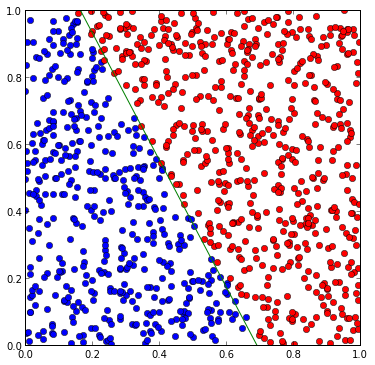

In [14]:
d,a0,a1 = w
d0 = data[labels<=0]
d1 = data[labels>0]
figure(figsize=(6,6))
ylim((0,1))
xlim((0,1))
plot(d0[:,0],d0[:,1],"bo")
plot(d1[:,0],d1[:,1],"ro")
plot([0,-d/a0],[-d/a1,0],"g")
print len(d0),len(d1)

That looks quite good, but not perfect.  Let's look at the value of the discriminant function.

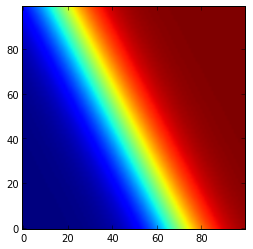

In [15]:
xs = linspace(0,1,100)[:,newaxis]
ys = linspace(0,1,100)[newaxis,:]
cla(); imshow(sigmoid(a0*xs+a1*ys+d).T,origin='lower'); savefig("temp.png")

Blue represents zero and red represents one.  From this picture, we can see that the transition region between the two values is quite fuzzy; the decision boundary isn't at all sharp.

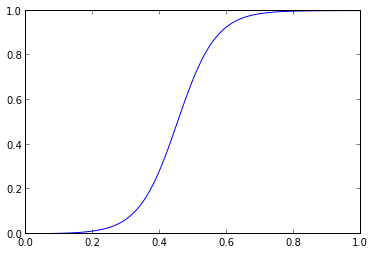

In [16]:
xs = linspace(0,1,100)
ys = xs
cla(); plot(xs,sigmoid(a0*xs+a1*ys+d)); savefig("temp.png")

Let's update a little longer and with a higher training rate.

In [17]:
eta = 0.1
for iter in range(500000):
    i = iter%len(data)
    if iter%100000==0: print iter,eta,w
    x = augmented[i]
    c = labels[i]
    s = sigmoid(dot(w,x))
    sprime = s*(1-s)
    delta = s-c
    w -= eta*(s-c)*sprime*x

0 0.1 [ -7.84683128  11.35962138   5.98575717]
100000 0.1 [-11.60182816  16.61438497   9.00802051]
200000 0.1 [-13.81577983  19.70742599  10.76316596]
300000 0.1 [-15.46759654  22.01714172  12.07428822]
400000 0.1 [-16.81496314  23.90180674  13.14491147]

Now the decision boundary is a lot "sharper":

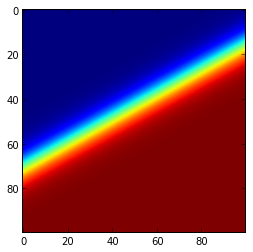

In [20]:
d,a0,a1 = w
xs = linspace(0,1,100)[:,newaxis]
ys = linspace(0,1,100)[newaxis,:]
cla(); imshow(sigmoid(a0*xs+a1*ys+d))

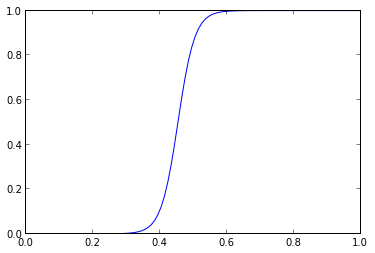

In [19]:
xs = linspace(0,1,100)
ys = xs
cla(); plot(xs,sigmoid(a0*xs+a1*ys+d))

Let's do more of that still.

In [21]:
eta = 1.0
for iter in range(500000):
    i = iter%len(data)
    if iter%100000==0: print iter,eta,w
    x = augmented[i]
    c = labels[i]
    s = sigmoid(dot(w,x))
    sprime = s*(1-s)
    delta = s-c
    w -= eta*(s-c)*sprime*x

0 1.0 [-17.9677928   25.51467577  14.06171267]
100000 1.0 [-25.35304656  35.90923298  20.11625363]
200000 1.0 [-30.01543776  42.40278885  23.80803724]
300000 1.0 [-33.64150081  47.45434356  26.67869104]
400000 1.0 [-36.69066627  51.70397516  29.09337889]

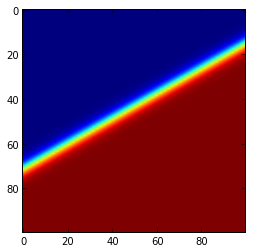

In [22]:
d,a0,a1 = w
xs = linspace(0,1,100)[:,newaxis]
ys = linspace(0,1,100)[newaxis,:]
cla(); imshow(sigmoid(a0*xs+a1*ys+d))

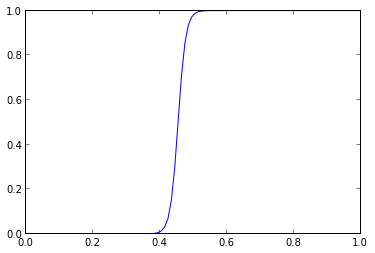

In [23]:
xs = linspace(0,1,100)
ys = xs
cla(); plot(xs,sigmoid(a0*xs+a1*ys+d)); savefig("temp.png")

Using scikit-learn
==================

In [24]:
from sklearn import linear_model,datasets

In [25]:
logreg = linear_model.LogisticRegression(C=1e5)

In [26]:
logreg.fit(data,labels)

LogisticRegression(C=100000.0, dual=False, fit_intercept=True,
          intercept_scaling=1, penalty='l2', scale_C=False, tol=0.0001)

In [32]:
z = logreg.predict(data)
print 1*labels[:10]
print z[:10]
print "errors",sum(z!=labels)

[1 1 1 1 0 0 1 1 0 1]
[1 1 1 1 0 0 1 1 0 1]
errors 0